# WASP-50 analysis
Author: Néstor Espinoza (nespinoza@stsci.edu)

Let's start by importing relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import juliet

Let's download WASP-50 lightcurves:

In [2]:
t,f,ferr = juliet.get_all_TESS_data('WASP-50b')

Which sector is this data from?

In [3]:
t.keys()

dict_keys(['TESS4'])

Sector 4. Now let's see how this data looks like:

(0.907728944439441, 26.838195462711155)

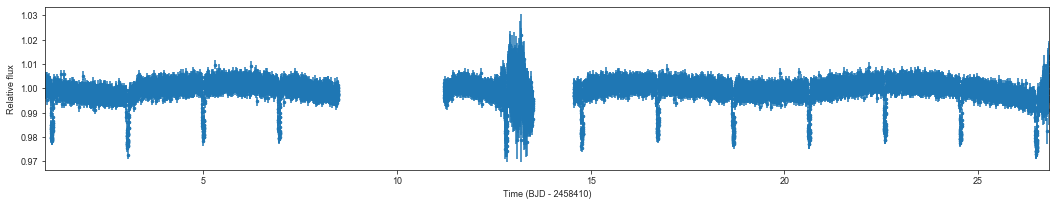

In [4]:
tstart = t['TESS4'][0]
tend = t['TESS4'][-1]
plt.figure(figsize=(18,3))
plt.errorbar(t['TESS4']-int(tstart), f['TESS4'],ferr['TESS4'],fmt='.')
plt.xlabel(f'Time (BJD - {int(tstart)})')
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])

## Fitting it like in the paper

In the paper this is fit using a more or less strict period and time-of-transit center prior based on a fairly old reference: [Gillon et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011A%26A...533A..88G/abstract). Let's see if we obtain the same results as in the paper here:

In [5]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4','q2_TESS4','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_TESS4', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
         'GP_timescale_TESS4']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[1.9550959, 0.0000051], [2458000+411.097,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [1,100.], 1.0, [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [6]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, out_folder = 'WASP-50b-ExpMatern')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 1000)

  analysing data from WASP-50b-ExpMatern/jomnest_.txt


Let's see how the fit looks like:

(-5000, 5000)

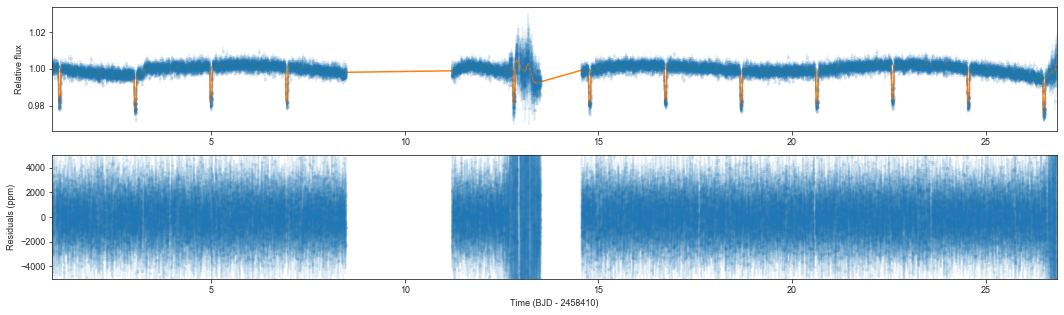

In [10]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
plt.errorbar(dataset.times_lc['TESS4']-int(tstart), dataset.data_lc['TESS4'], \
             yerr = dataset.errors_lc['TESS4'], fmt = '.', alpha = 0.1)

# Plot the model:
model = results.lc.evaluate('TESS4')
plt.plot(dataset.times_lc['TESS4']-int(tstart), model)

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
plt.errorbar(dataset.times_lc['TESS4']-int(tstart), (dataset.data_lc['TESS4'] - model)*1e6, \
         yerr = dataset.errors_lc['TESS4']*1e6, fmt = '.', alpha = 0.1)
plt.ylabel('Residuals (ppm)')
plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

That looks good. What about the phased lightcurve?

dict_keys(['ones', 'M', 'LM', 'deterministic', 'deterministic_errors', 'params', 'm', 'p1', 'deterministic_variances', 'GP'])


(-2500, 2500)

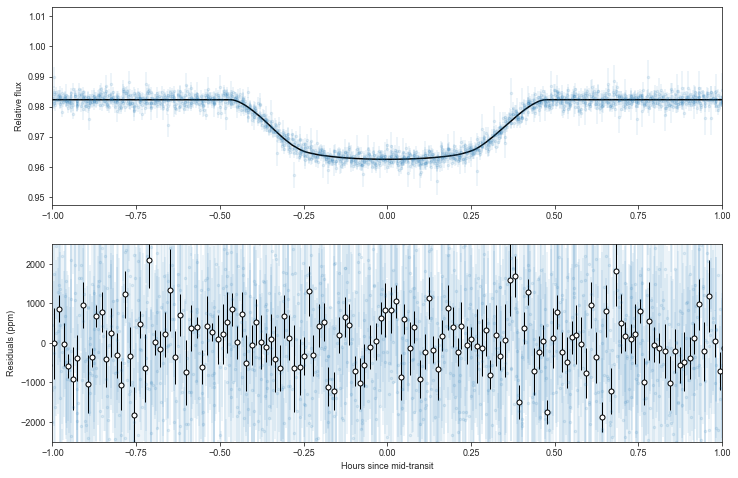

In [13]:
# Get phases:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \
        np.median(results.posteriors['posterior_samples']['t0_p1'])

phases = juliet.utils.get_phases(dataset.times_lc['TESS4'], P, t0)

# Plot:
plt.figure(figsize=(12,8))

plt.subplot(211)
# Extract model components:
transit_model = results.lc.model['TESS4']['deterministic']
gp_component = results.lc.model['TESS4']['GP']
print(results.lc.model['TESS4'].keys())

# Plot the data:
plt.errorbar(phases*24, dataset.data_lc['TESS4'] - gp_component, \
             yerr = dataset.errors_lc['TESS4'], fmt = '.', alpha = 0.1)

# Plot the model:
idx = np.argsort(phases)
plt.plot(phases[idx]*24, transit_model[idx] ,color='black')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([-1.,1.])
# Plot residuals:
plt.subplot(212)
plt.errorbar(phases*24, (dataset.data_lc['TESS4'] - model)*1e6, \
             yerr = (dataset.errors_lc['TESS4'])*1e6, fmt = '.', alpha = 0.1)

pbin,ybin,ybinerr = juliet.utils.bin_data(phases[idx]*24, (dataset.data_lc['TESS4'][idx] - model[idx])*1e6, 10)
plt.errorbar(pbin,ybin,yerr=ybinerr,fmt='o',mfc='white',mec='black',ecolor='black',elinewidth=1)
plt.xlabel('Hours since mid-transit')
plt.ylabel('Residuals (ppm)')
plt.xlim([-1.,1.])
plt.ylim([-2500,2500])

All right, that looks nice. Now let's check the timing --- what time-of-transit do we get?

In [14]:
print(np.median(results.posteriors['posterior_samples']['t0_p1']),np.sqrt(np.var(results.posteriors['posterior_samples']['t0_p1'])))

2458411.092967623 0.0002258055857024548


That's okay.

u1 = 0.312 +/- 0.223 u2 = 0.456 +/- 0.314


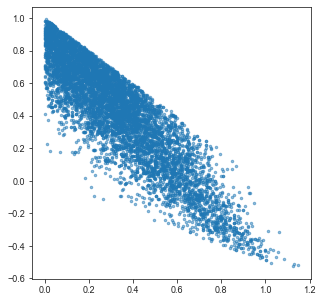

In [15]:
fig = plt.figure(figsize=(5,5))
# Store posterior samples for q1 and q2:
q1, q2 = results.posteriors['posterior_samples']['q1_TESS4'],\
          results.posteriors['posterior_samples']['q2_TESS4']

# Transform back to (u1,u2):
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot posterior distribution:
plt.plot(u1,u2,'.',alpha=0.5)
u1_m,u1_err = np.median(u1), np.sqrt(np.var(u1))
u2_m,u2_err = np.median(u2), np.sqrt(np.var(u2))


print('u1 = {0:.3f} +/- {1:.3f}'.format(u1_m,u1_err), 'u2 = {0:.3f} +/- {1:.3f}'.format(u2_m,u2_err))

Relatively large errobars --- but interestingly, the value does not match the ones in the paper. Let's try the same fit, but with the QP Kernel:

In [19]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4','q2_TESS4','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_TESS4', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_B_TESS4', 'GP_C_TESS4', \
         'GP_L_TESS4','GP_Prot_TESS4']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform', \
        'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[1.9550959, 0.0000051], [2458000+411.097,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [1,100.], 1.0, [0.,0.1], [0.1, 10000.], [1e-5, 1000.], [1e-5, 1000.], [1e-5, 1000.], \
                      [0.1,30]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [20]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, out_folder = 'WASP-50b-QP')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 1000)

  analysing data from WASP-50b-QP/jomnest_.txt


(-5000, 5000)

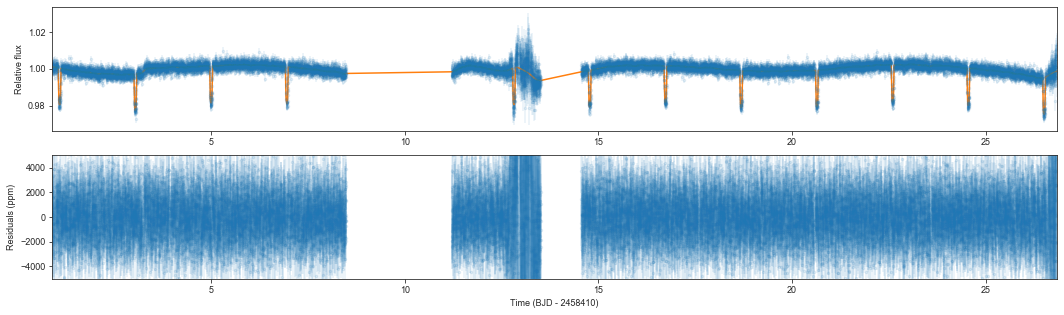

In [25]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
plt.errorbar(dataset.times_lc['TESS4']-int(tstart), dataset.data_lc['TESS4'], \
             yerr = dataset.errors_lc['TESS4'], fmt = '.', alpha = 0.1)

# Plot the model:
model = results.lc.evaluate('TESS4')
plt.plot(dataset.times_lc['TESS4']-int(tstart), model)

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
plt.errorbar(dataset.times_lc['TESS4']-int(tstart), (dataset.data_lc['TESS4'] - model)*1e6, \
         yerr = dataset.errors_lc['TESS4']*1e6, fmt = '.', alpha = 0.1)
plt.ylabel('Residuals (ppm)')
plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

dict_keys(['ones', 'M', 'LM', 'deterministic', 'deterministic_errors', 'params', 'm', 'p1', 'deterministic_variances', 'GP'])


(-2500, 2500)

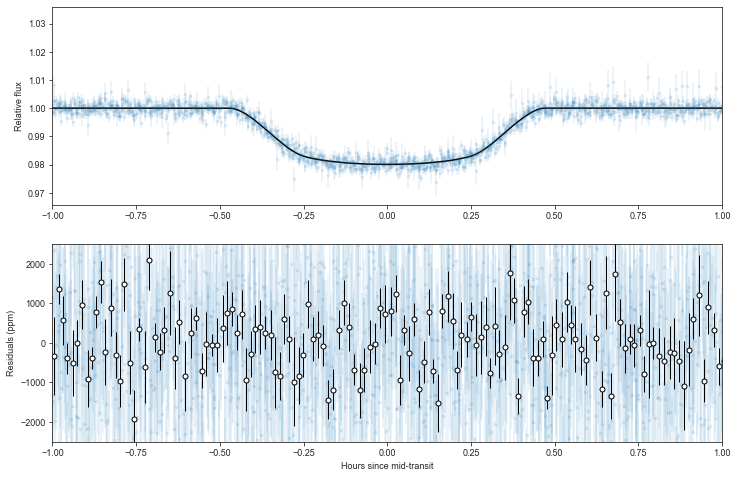

In [22]:
# Get phases:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \
        np.median(results.posteriors['posterior_samples']['t0_p1'])

phases = juliet.utils.get_phases(dataset.times_lc['TESS4'], P, t0)

# Plot:
plt.figure(figsize=(12,8))

plt.subplot(211)
# Extract model components:
transit_model = results.lc.model['TESS4']['deterministic']
gp_component = results.lc.model['TESS4']['GP']
print(results.lc.model['TESS4'].keys())

# Plot the data:
plt.errorbar(phases*24, dataset.data_lc['TESS4'] - gp_component, \
             yerr = dataset.errors_lc['TESS4'], fmt = '.', alpha = 0.1)

# Plot the model:
idx = np.argsort(phases)
plt.plot(phases[idx]*24, transit_model[idx] ,color='black')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([-1.,1.])
# Plot residuals:
plt.subplot(212)
plt.errorbar(phases*24, (dataset.data_lc['TESS4'] - model)*1e6, \
             yerr = (dataset.errors_lc['TESS4'])*1e6, fmt = '.', alpha = 0.1)

pbin,ybin,ybinerr = juliet.utils.bin_data(phases[idx]*24, (dataset.data_lc['TESS4'][idx] - model[idx])*1e6, 10)
plt.errorbar(pbin,ybin,yerr=ybinerr,fmt='o',mfc='white',mec='black',ecolor='black',elinewidth=1)
plt.xlabel('Hours since mid-transit')
plt.ylabel('Residuals (ppm)')
plt.xlim([-1.,1.])
plt.ylim([-2500,2500])

Basically the same result. Time of transit?

In [23]:
print(np.median(results.posteriors['posterior_samples']['t0_p1']),np.sqrt(np.var(results.posteriors['posterior_samples']['t0_p1'])))


2458411.0930708516 0.0001145972536358245


u1 = 0.210 +/- 0.187 u2 = 0.527 +/- 0.295


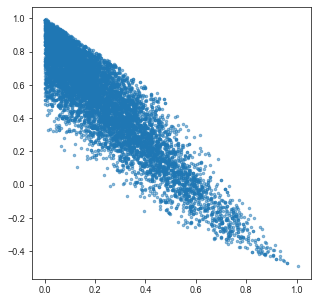

In [24]:
fig = plt.figure(figsize=(5,5))
# Store posterior samples for q1 and q2:
q1, q2 = results.posteriors['posterior_samples']['q1_TESS4'],\
          results.posteriors['posterior_samples']['q2_TESS4']

# Transform back to (u1,u2):
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot posterior distribution:
plt.plot(u1,u2,'.',alpha=0.5)
u1_m,u1_err = np.median(u1), np.sqrt(np.var(u1))
u2_m,u2_err = np.median(u2), np.sqrt(np.var(u2))


print('u1 = {0:.3f} +/- {1:.3f}'.format(u1_m,u1_err), 'u2 = {0:.3f} +/- {1:.3f}'.format(u2_m,u2_err))

Much better constrained than the ExpMatern kernel. Interestingly, values are different from the ones in the paper, but still apparently inconsistent with the theoretical values.